In [27]:
# Simple Fashion Classifier via using MNIST and MamaNet1 (Garment Classification)
"""
This module is developed by Suanfamama.

Authors:
- Wei Jiang (wei@suanfamama.com)
- Mama Xiao (mama.xiao@suanfamama.com)

Reference:
- Training with PyTorch
- https://pytorch.org/tutorials/beginner/introyt/trainingyt.html?highlight=nn%20crossentropyloss
"""

'\nThis module is developed by Suanfamama.\n\nAuthors:\n- Wei Jiang (wei@suanfamama.com)\n- Mama Xiao (mama.xiao@suanfamama.com)\n\nReference:\n- Training with PyTorch\n- https://pytorch.org/tutorials/beginner/introyt/trainingyt.html?highlight=nn%20crossentropyloss\n'

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt', 'Trouser裤子', 'Pullover套衫', 'Dress裙子', 'Coat大衣',
        'Sandal拖鞋', 'Shirt衬衫', 'Sneaker运动鞋', 'Bag包', 'Ankle Boot靴子')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Ankle Boot靴子  Shirt衬衫  Trouser裤子  Pullover套衫


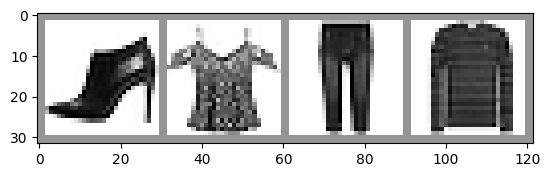

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [30]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class MamaNet1(nn.Module):
    def __init__(self):
        super(MamaNet1, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = MamaNet1()

In [31]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.5485, 0.7683, 0.3454, 0.3769, 0.6439, 0.8107, 0.1724, 0.0062, 0.8270,
         0.7843],
        [0.0786, 0.6898, 0.4818, 0.5824, 0.4287, 0.9545, 0.5508, 0.8485, 0.6842,
         0.0202],
        [0.4862, 0.8087, 0.7052, 0.3607, 0.0788, 0.0985, 0.9911, 0.2691, 0.9437,
         0.2372],
        [0.2213, 0.8141, 0.4777, 0.5049, 0.5748, 0.1172, 0.5216, 0.9315, 0.7901,
         0.6650]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.1179494857788086


In [32]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [33]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.308486503124237
  batch 2000 loss: 2.306666962862015
  batch 3000 loss: 2.308485664129257
  batch 4000 loss: 2.306562722682953
  batch 5000 loss: 2.3074491751194
  batch 6000 loss: 2.3070131552219393
  batch 7000 loss: 2.306592314481735
  batch 8000 loss: 2.305363685846329
  batch 9000 loss: 2.307647428750992
  batch 10000 loss: 2.3074215140342713
  batch 11000 loss: 2.306654824972153
  batch 12000 loss: 2.3053947763442992
  batch 13000 loss: 2.3063714435100557
  batch 14000 loss: 2.307096037864685
  batch 15000 loss: 2.3075469677448273
LOSS train 2.3075469677448273 valid 2.306988477706909
EPOCH 2:
  batch 1000 loss: 2.3067321128845215
  batch 2000 loss: 2.307628496646881
  batch 3000 loss: 2.3067675349712373
  batch 4000 loss: 2.306414767742157
  batch 5000 loss: 2.308210854053497
  batch 6000 loss: 2.306331182718277
  batch 7000 loss: 2.306460241317749
  batch 8000 loss: 2.3070568709373473
  batch 9000 loss: 2.306172536611557
  batch 10000 loss: 2.306137

In [34]:
    # Save the model checkpoint
    import os
    model_save_dir = "./"  # Directory to save the models
    model_path = os.path.join(model_save_dir, f'MamaNet1_Garment_Classification.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

Model saved to ./MamaNet1_Garment_Classification.pth
